# Part II: Building a dataset and data exploration

Authors: Jordi Bolibar & Facundo Sapienza

Once we have successfully retrieved the training dataset using OGGM, we can start exploring and understanding the dataset. The goal of this notebook will be to perform some basic data analysis techniques on the data, and to understand the physical reasons behind the selected features for the model. 

> **_NOTE_** Before running this notebook, make sure your Jupyter kernel (top left corner of the notebook) has been configured to work with the *Finse_MB* conda environment. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## 2.1 Data Preparation

The MB remote sensing from Hugonnet et al. (2021) covers periods of 10 years (2000-2010 and 2010-2020). We will process the feature matrix to match these 10 year intervals. First of all, we will assign to each hydrological year in every period 2000-2010 and 2010-2020 the same part of mass balance that results from grabing the total mass balance from the period and divide it by 10. 

In [2]:
df_target = pd.read_csv('Data/mb_df.csv')

# Restrict to the two target peroids we have for training
df_target = df_target.replace({'2000-01-01_2010-01-01': '2000-2010',
                               '2010-01-01_2020-01-01': '2010-2020'})
df_target = df_target[df_target.period.isin(['2000-2010', '2010-2020'])]
# We add an unique id to each row to recognized repeited measurements 
df_target['target_id'] = np.arange(0, df_target.shape[0])

# Add hydro year of the target 
dfs = []
for i in range(10):
    df_ = df_target.copy()
    df_['hydro_year'] = np.select([(df_.period=='2000-2010'),
                                         (df_.period=='2010-2020')], 
                                         [2000+i, 2010+i])
    dfs.append(df_)

df_target = pd.concat(dfs, axis=0)
df_target = df_target.set_index(['rgi_id', 'hydro_year'])
df_target = df_target.sort_values(['rgi_id', 'hydro_year'])
df_target = df_target[['dmdtda', 'err_dmdtda', 'period','target_id']]
df_target

dmdtda  err_dmdtda     period  target_id
rgi_id         hydro_year                                            
RGI60-08.00001 2000       -0.458772     0.44912  2000-2010          0
               2001       -0.458772     0.44912  2000-2010          0
               2002       -0.458772     0.44912  2000-2010          0
               2003       -0.458772     0.44912  2000-2010          0
               2004       -0.458772     0.44912  2000-2010          0
...                             ...         ...        ...        ...
RGI60-08.03417 2015        0.389200     0.49660  2010-2020       6833
               2016        0.389200     0.49660  2010-2020       6833
               2017        0.389200     0.49660  2010-2020       6833
               2018        0.389200     0.49660  2010-2020       6833
               2019        0.389200     0.49660  2010-2020       6833

[68340 rows x 4 columns]

This DataFrame provides us the average change in altitude per year `dmdtda` for each glacier in Scandinavia. It also providees the estimated error `err_dmdtda`, which as you can see, it is really large for small glaciers. Bear in mind that these annual surface changes are obtained just by dividing the 10-year change from the 2000-2010 and 2010-2020 periods. 

We now read the feature matrix (X) and merge it with the target response (Y, the MB data from Hugonnet et al.(2021)).

In [3]:
df_features = pd.read_csv('Data/training_df.csv', index_col=['rgi_id', 'hydro_year'])
df_features

PDD          RGI_ID  area  icecap     lat  \
rgi_id         hydro_year                                                    
RGI60-08.00001 2000        40.322890  RGI60-08.00001  0.03       0  67.930   
               2001        42.489556  RGI60-08.00001  0.03       0  67.930   
               2002        38.044445  RGI60-08.00001  0.03       0  67.930   
               2003        39.844445  RGI60-08.00001  0.03       0  67.930   
               2004        40.577779  RGI60-08.00001  0.03       0  67.930   
...                              ...             ...   ...     ...     ...   
RGI60-08.03417 2015        51.437776  RGI60-08.03417  0.15       0  65.923   
               2016        55.643333  RGI60-08.03417  0.15       0  65.923   
               2017        50.003331  RGI60-08.03417  0.15       0  65.923   
               2018        57.004444  RGI60-08.03417  0.15       0  65.923   
               2019        54.643332  RGI60-08.03417  0.15       0  65.923   

                              prcp_01     prcp_02     prcp_03     prcp_04  \
rgi_id         hydro_year                                                   
RGI60-08.00001 2000         89.949440   39.799580   51.759113   50.980053   
               2001         50.515020   43.414460   49.670944   27.386324   
               2002         59.345170   29.263450   24.280972   44.494130   
               2003         48.070133   34.243984   27.780344   46.093716   
               2004         78.174040   31.993261   62.266920   28.106590   
...                               ...         ...         ...         ...   
RGI60-08.03417 2015        104.149030  111.409660  266.413970  155.734220   
               2016        217.098800  211.801880  242.586320  101.253310   
               2017         89.045910  149.197240  371.887760  299.347630   
               2018        176.113360  158.276730  192.674560   64.232956   
               2019        217.587550  137.044170  171.008670  167.764050   

                              prcp_05  ...    temp_06   temp_07   temp_08  \
rgi_id         hydro_year              ...                                  
RGI60-08.00001 2000         29.002270  ...  -6.611111 -1.732222  3.233333   
               2001         35.375156  ... -12.011110 -1.865555  1.533333   
               2002         44.540123  ...  -8.044444 -0.898889  3.333334   
               2003         26.073019  ...  -5.611111 -3.232222  4.133333   
               2004         40.665600  ...  -7.111110 -2.298889  3.033333   
...                               ...  ...        ...       ...       ...   
RGI60-08.03417 2015        189.870130  ...  -2.700000 -1.488889  2.322222   
               2016        108.876656  ...  -3.800000 -1.455556  4.088889   
               2017        121.731080  ...  -5.200000 -2.988889  1.355555   
               2018         24.806946  ...  -8.999999 -1.488889  5.588889   
               2019        227.375120  ...  -6.400000  0.211111  2.022222   

                             temp_09    temp_10    temp_11   temp_12    zmax  \
rgi_id         hydro_year                                                      
RGI60-08.00001 2000         9.202221  13.494446  10.450000  5.927779   250.0   
               2001        10.002221  13.594445  10.316667  7.627779   250.0   
               2002         9.202221  13.794446  10.316667  4.727778   250.0   
               2003         6.135554  15.094445  11.316667  6.494445   250.0   
               2004         8.102222  14.727779  11.216666  6.827778   250.0   
...                              ...        ...        ...       ...     ...   
RGI60-08.03417 2015         5.307778   8.482221  10.999999  6.890000  1318.0   
               2016         6.907778  10.382221   8.599999  7.290001  1318.0   
               2017         7.507778   9.482221   8.799999  6.890000  1318.0   
               2018         6.007778  12.582221   9.400000  5.990001  1318.0   
               2019         7.674444  10.182220   9.99

We aggregate the periods 2000-2010 and 2010-2020 into one single datapoint for training by setting `aggregation=True`. This makes sense if we are interested in learning just the mass balance in these 10 years periods. Going for an annual resolution instead of the 10-year resolution of the target dataset doesn't make much sense. The spatiotemporal resolution of the dataset we have limits model capabilities (see  explanations below in section "**Choosing the right data and understanding the implications in model design**").

In [4]:
aggregation = True

df_all = df_features.merge(df_target, 
                           left_on=['rgi_id','hydro_year'], 
                           right_on=['rgi_id','hydro_year']).drop(['RGI_ID'], axis=1)

if aggregation:
    df_all = df_all.groupby(['rgi_id', 'period']).mean()
df_all

PDD    area  icecap     lat     prcp_01  \
rgi_id         period                                                     
RGI60-08.00001 2000-2010  39.787001   0.030     0.0  67.930   59.556398   
               2010-2020  41.833601   0.030     0.0  67.930   57.685775   
RGI60-08.00002 2000-2010  44.907200   0.030     0.0  67.870   62.082497   
               2010-2020  46.980223   0.030     0.0  67.870   59.345685   
RGI60-08.00003 2000-2010  35.337201   0.020     0.0  67.820   60.485810   
...                             ...     ...     ...     ...         ...   
RGI60-08.03415 2010-2020  34.757735   0.056     0.0  66.729  131.108065   
RGI60-08.03416 2000-2010  66.325377  14.152     0.0  66.006  160.244277   
               2010-2020  66.505066  14.152     0.0  66.006  174.868147   
RGI60-08.03417 2000-2010  53.358777   0.150     0.0  65.923  152.880332   
               2010-2020  53.116888   0.150     0.0  65.923  165.529468   

                             prcp_02     prcp_03     prcp_04     prcp_05  \
rgi_id         period                                                      
RGI60-08.00001 2000-2010   42.393607   49.464068   40.707838   28.460900   
               2010-2020   45.119089   49.848962   37.706104   33.120270   
RGI60-08.00002 2000-2010   43.677873   49.432192   41.313322   28.519503   
               2010-2020   45.845166   49.957571   37.644466   32.577409   
RGI60-08.00003 2000-2010   45.600863   55.059464   46.842254   33.796713   
...                              ...         ...         ...         ...   
RGI60-08.03415 2010-2020  107.707591  144.610990   98.574383   92.859806   
RGI60-08.03416 2000-2010  183.438569  186.103358  190.792902  139.485696   
               2010-2020  146.277851  205.123464  136.355639  129.459209   
RGI60-08.03417 2000-2010  173.554018  177.555157  183.980329  133.112843   
               2010-2020  138.168895  196.729779  132.081722  123.916238   

                             prcp_06  ...   temp_09    temp_10    temp_11  \
rgi_id         period                 ...                                   
RGI60-08.00001 2000-2010   32.946557  ...  8.765555  13.037779  10.950000   
               2010-2020   41.740137  ...  8.942221  13.034446  11.120000   
RGI60-08.00002 2000-2010   32.153049  ...  9.274814  13.517038  11.384073   
               2010-2020   40.674079  ...  9.423703  13.538149  11.500740   
RGI60-08.00003 2000-2010   38.831589  ...  7.059999  11.433335   9.346666   
...                              ...  ...       ...        ...        ...   
RGI60-08.03415 2010-2020  111.586080  ...  4.860000   8.513335   7.726667   
RGI60-08.03416 2000-2010  115.362394  ...  6.778889   9.997777   9.253333   
               2010-2020  140.041785  ...  6.448889   9.764443   9.126666   
RGI60-08.03417 2000-2010  112.064028  ...  7.277778  10.505554   9.549999   
               2010-2020  134.381284  ...  6.947778  10.288887   9.436666   

                           temp_12    zmax    zmed    zmin    dmdtda  \
rgi_id         period                                                  
RGI60-08.00001 2000-2010  6.391112   250.0   242.0   235.0 -0.458772   
               2010-2020  7.227779   250.0   242.0   235.0 -0.356250   
RGI60-08.00002 2000-2010  6.784445   246.0   239.0   228.0 -0.458772   
               2010-2020  7.632223   246.0   239.0   228.0 -0.356250   
RGI60-08.00003 2000-2010  4.700001   749.0   726.0   701.0 -0.458772   
...                            ...     ...     ...     ...       ...   
RGI60-08.03415 2010-2020  4.133333  1330.0  1314.0  1289.0  0.534500   
RGI60-08.03416 2000-2010  5.060001  1811.0  1581.0   890.0 -0.737400   
               2010-2020  5.783334  1811.0  1581.0   890.0 -0.649400   
RGI60-08.03417 2000-2010  5.363334  1318.0  1186.0  1090.0 -0.616100   
               2010-2020  6.070001  1318.0  1186.0  1090.0  0.389200   

                          err_dmdtda  target_id  
rgi_id         period                            
RGI60-08.00001 2000-2010    

Now that we have a DataFrame with the full dataset, including the feature matrix (X) and the target MB data (Y), we can save it in a file to be used later. 

In [5]:
df_all.to_csv('Data/df_all.csv')

## 2.2 Preliminary statistics of the dataset

In this section we are going to explore the dataset we have, in order to better understand the data we will feed into our models. 

A simple look at the mass balance distribution shows that most of the mass balance rates of Scandinavian glaciers between 2000-2010 and 2010-2020 are mostly negative. 

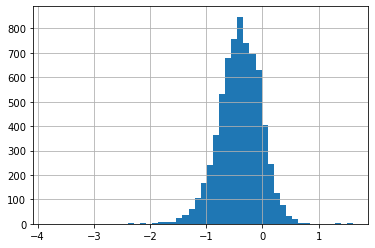

In [6]:
df_all['dmdtda'].hist(bins=50);

### [ **Exercice 1** ]
<img src="Figures/eye_logo.png" width="75"/>

What other sorts of data analyses can you think of? Implement them in this section by plotting different graphs and statistics. 

## 2.3 How to build a good dataset

In this section, we will discuss how to correctly build a good training dataset, in order to make sure that the models can successfully represent the physical processes that we are interested in. 

Now that we have the dataset ready, let's take a look at the features:

In [7]:
df_all.columns

Index(['PDD', 'area', 'icecap', 'lat', 'prcp_01', 'prcp_02', 'prcp_03',
       'prcp_04', 'prcp_05', 'prcp_06', 'prcp_07', 'prcp_08', 'prcp_09',
       'prcp_10', 'prcp_11', 'prcp_12', 'rain', 'slope', 'snow', 'temp_01',
       'temp_02', 'temp_03', 'temp_04', 'temp_05', 'temp_06', 'temp_07',
       'temp_08', 'temp_09', 'temp_10', 'temp_11', 'temp_12', 'zmax', 'zmed',
       'zmin', 'dmdtda', 'err_dmdtda', 'target_id'],
      dtype='object')

In this dataset we have already narrowed down a selection of training features for you. Nonetheless, in a research project, this step should not be taken for granted, since it can have a great impact on model design. 

### 2.3.1 Informed feature selection

The first question we should ask ouselves is: what variables affect the physical process we are trying to model here? In this case, we are talking about **glacier-wide mass balance**. Theory tells us that the integrated mass balance over the whole surface area of a glacier is impacted by both the climate and the topography of a glacier. 

Unlike for point mass balance, the hypsometry of a glacier has a great impact on its glacier-wide mass balance. This is mainly manifested in two ways:

- The glacier surface slope affects ice flow dynamics, particularly the creep component. Generally, steeper glaciers have higher ice velocities, which imply a faster transfer of ice from the higher altitudes in the accumulation area to the lower altitudes in the ablation area. At the same time, due to their span across a wider range of altitudes, steeper glaciers will retreat faster (i.e. smaller surface area and higher mean altitude), but they will be able to move to higher altiudes with a colder climate (Fig. 1a). This helps glaciers find new colder climates in an effort to reach equilibrium. On the other hand, flatter glaciers and ice caps will not retreate as fast, since they react mostly through thinning (Fig. 1b). This means that the glacier will move to lower altitudes with a warmer climate, further enhancing melt. This has an opposite effect to the one from steep mountain glaciers. 

- Steep mountain glaciers have a larger altitudinal range, meaning that their mass balance gradient will be steeper and likely more complex. For such glaciers, both ice flow dynamics and mass balance can play an important role in glacier evolution. On the other hand, small glaciers and to some extent ice caps, behave more similar to an ice cube: the reduced role of ice dynamics and their smaller altitudinal range imply a smaller mass balance gradient. For such glaciers, mass balance is the main contributor to glacier evolution. Nonetheless, in the current context of rapid climate change, even for glaciers with strong ice dynamics, the mass balance signal is completely dominating glacier changes. 

<img src="Figures/Hock_Huss_glacier_icecap.png" class="center" width="700"/>

*Figure 1. Retreat patterns for mountain glaciers and ice caps. Taken from Hock and Huss (2021)*

In order to correctly simulate glacier changes, these topographical feedbacks which affect the local climate of the glacier need to be taken into account in models. In the next section we will see how this relates to the spatiotemporal resolution of the datasets we use. In this case, it's the temporal resolution of the dataset which will dictate the complexity of our model. 


### 2.3.2 Choosing the right data and understanding the implications in model design

The next question when building a dataset would be: what available data at the spatial and temporal scales that we are trying to model can I access? 

Ideally, we would always want to have a dense spatiotemporal dataset covering all the possible dynamics in the physical process we want to model. However, sadly in reality this is (almost) never possible. Two main limitations are often present:

- The spatial and temporal resolution of the dataset are too low. The dataset might be rich in one of the two dimensions, e.g. a great spatial coverage, but it has a low temporal resolution (e.g. a multi-annual resolution). When using such data to train the model, we need to be mindful of the impact in model capabilities and performance. Training a model with such data will restrict its predicting capabilities to spatiotemporal resolutions similar to those it has seen during training. 

- The spatiotemporal coverage of the data. Even if the data has the right spatiotemporal resolution, it normally only covers part of the temporal and spatial domain we want to model. This is often the case for reconstruction problems, where we ask the model to "fill the gaps" in the dataset. For such cases, we need to be mindful of what type of data coverage we have, and what type of instances or data ranges we might be missing in the dataset. This will determine the capabilities of the model in terms of prediction and generalization. The more variability and dynamics are present in the dataset, the more chances we have to build a good model. For cases where important parts of the dynamics are missing, adding physical constraints (e.g. using PINNs or Universal Differential Equations) is a good way to overcome this. The physical constraints can help guide the learning, reducing the need for bigger and more complete datasets.

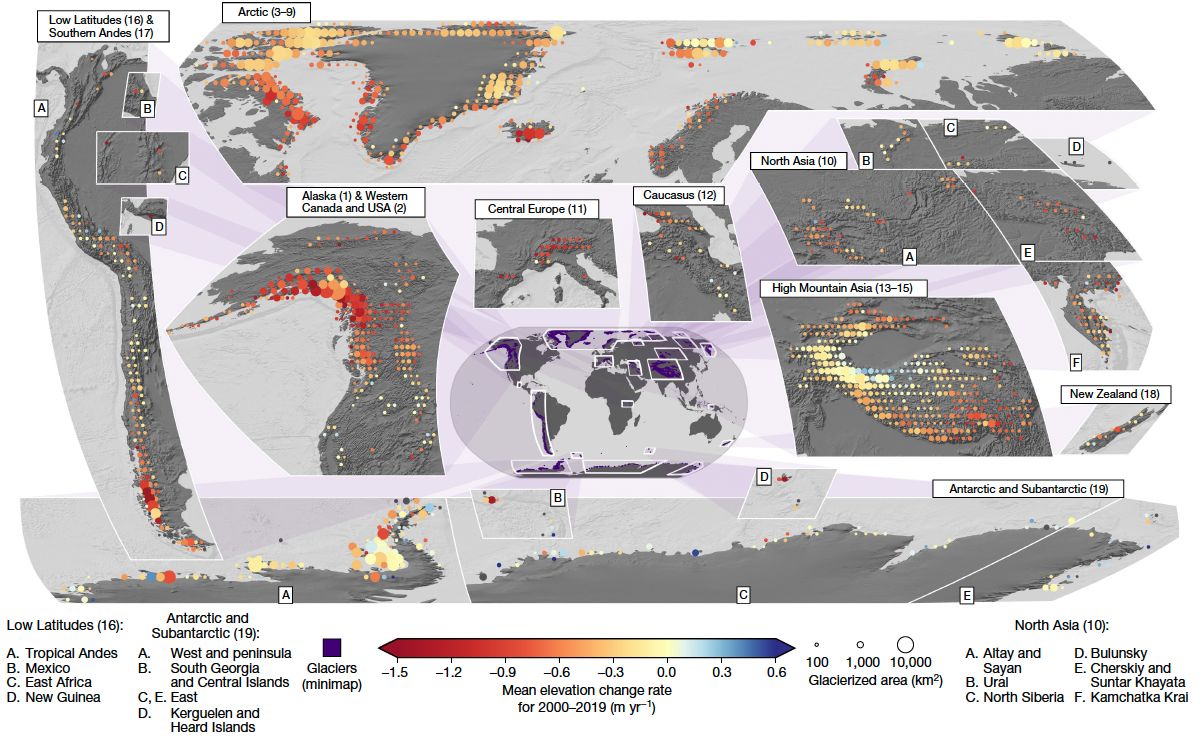
*Figure 2. Mass balance changes for the different glacierized regions of the world for the 2000-2019 period. Taken from Hugonnet et al. (2021)*

### 2.3.2 What about the dataset of this project?

The dataset of this project has a very good *spatial* coverage, since it covers the whole region of Scandinavia. However, it has a very poor *temporal* resolution, since we only have two periods of 10 years as target data (the dataset from Hugonnet et al. 2021, from Fig. 2). As we mentioned before, this will totally dictate the predictive power of the our models, and we need to be aware of it. 

The good spatial coverage will imply that our models will probably be able to learn the spatial variability of the mass balance signal across Scandinavia. On the other hand, since we only have two snapshots of mass balance changes for periods of 10 years, the prediction of mass balance changes in time will be extremely limited. 

This limitation in predictions in the temporal domain is also manifested in another way. We saw how glacier-wide mass balance is affected both by climate and topography. Since in our current dataset we only have a single snapshot of the topography of Scandinavian glaciers, this means that we will not be able to constrain correctly glacier changes that deviate a lot from the snapshot date (i.e. around 2003 from the Randolph Glacier Inventory). If we attempt to make predictions far into the future, the "future" morphology of Scandinavian glaciers will have changed too much with respect to the one from our training dataset, making it impossible for the model to understand how the future topography and dynamics will modulate the mass balance signal. This is beyond the scope of this project, since the goal here is to learn and understand the machine learning aspects of the model. Nonetheless, it is important to be aware of the limitations of the models we are designing. If we wanted to bypass this limitation, we could do so in two different ways:

- For past reconstructions of glacier mass balance changes, we could use multiple glacier inventories, providing us with glacier area changes,  mean, max, and min altitude and slope changes. By feeding this into our models, and potentially interpolating between inventories, we could constrain the topographical signal of glacier evolution, making it possible for the models to correctly simulate glacier changes through many decades. This would improve the *temporal* resolution of our model, thus making it possible to successfully make predictions in the temporal domain. 

- For future projections, it is no longer possible to use inventories, since they don't exist for obvious reasons. Therefore, it is necessary to use a proper ice dynamics module from a glacier evolution model. This implies using simple empirical parameterizations (e.g. Huss et al. 2008), or explicit numerical representation of the ice flow dynamics (e.g. using the Shallow Ice Approximation of Full-Stokes).

In the next notebook we will start training the machine learning models with the dataset we have gathered. In order to keep things simple and to focus on the machine learning aspects of the project, we will content ourselves with simulating the mass balance changes of Scandinavian glaciers for the last 20 years, in 10-year intervals, constrained by the Hugonnet et al. (2021) dataset. 